<div class="notebook-buttons" style="display:flex; padding-top: 5rem;padding-bottom: 2.5rem;line-height: 2.15;">
    <a href="https://colab.research.google.com/github/zazuko/notebooks/blob/master/notebooks/animal-disease/epidemics.ipynb">
        <div id="colab-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; align-items: center;">
            <img class="call-to-action-img" src="img//colab.svg" width="30" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">Run in Google Colab</div>
        </div>
    </a>
    <a href="https://raw.githubusercontent.com/zazuko/notebooks/master/notebooks/animal-disease/epidemics.ipynb" download>
        <div id="download-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; height: auto;align-items: center;">
            <img class="call-to-action-img" src="img//download.svg" width="22" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">Download Notebook</div>
        </div>
    </a>
    <a href="https://github.com/zazuko/notebooks/blob/master/notebooks/animal-disease/epidemics.ipynb">
        <div id="github-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; height: auto;align-items: center;">
            <img class="call-to-action-img" src="img//github.svg" width="25" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">View on GitHub</div>
        </div>
    </a>
</div>

# Animal epidemics in Switzerland

FOAG, Federal Office for Agriculture, collects data on the animal diseases in Switzerland. This data is published as [Linked Data](https://en.wikipedia.org/wiki/Linked_data). 

In this tutorial, we will show **how to work with Linked Data.** Mainly, we will see how to work with data on animal epidemics.   
We will look into how to query, process, and visualize it.   

## Ideas

* Animal hierarchy
* Disease hierarchy
* Number of reports per gde, over time (https://python-visualization.github.io/folium/plugins.html#folium.plugins.TimeSliderChoropleth)

* Serious outbreaks: find reports where stock == killed

In [23]:
import json

import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from graphly.api_client import SparqlClient

In [24]:
sparql = SparqlClient("https://int.lindas.admin.ch/query")
geosparql = SparqlClient("https://ld.geo.admin.ch/query")

sparql.add_prefixes({
    "schema": "<http://schema.org/>",
    "cube": "<https://cube.link/>",
    "admin": "<https://schema.ld.admin.ch/>",
    "skos": "<http://www.w3.org/2004/02/skos/core#>",
    "disease": "<https://environment.ld.admin.ch/foen/animal-pest/>"   
})

geosparql.add_prefixes({
    "dct": "<http://purl.org/dc/terms/>",
    "geonames": "<http://www.geonames.org/ontology#>",
    "schema": "<http://schema.org/>",
    "geosparql": "<http://www.opengis.net/ont/geosparql#>",
})

### Animals hierarchy

In [25]:
query = """
SELECT DISTINCT ?specie ?group
WHERE {
  ?s disease:animal-specie ?specieIRI.
  ?specieIRI schema:name ?specie.
  
  ?specieIRI skos:broader/schema:name ?group.
  
  FILTER (LANG(?specie) = "de")
  FILTER (LANG(?group) = "de")
} 
ORDER BY ?group
"""

df = sparql.send_query(query)
df.head()

,specie,group
0,Anderes Haustier,Andere Haustiere
1,Bienen,Bienen
2,Pferd,Equiden
3,Krebs,Fische
4,Fisch,Fische


## Disease hierarchy

In [26]:
query = """
SELECT DISTINCT ?epidemics ?group
WHERE {
  ?s disease:epidemics ?epidemicsIRI.
  ?epidemicsIRI schema:name ?epidemics.
  
  ?epidemicsIRI skos:broader/schema:name ?group.

  FILTER (LANG(?epidemics) = "de")
  FILTER (LANG(?group) = "de")
}
ORDER BY ?group
"""

df = sparql.send_query(query)
df.head()

,epidemics,group
0,Bovine Virusdiarrhoe / Mucosal Disease,Auszurottende Seuchen
1,Brucellose der Rinder,Auszurottende Seuchen
2,Tollwut,Auszurottende Seuchen
3,Infektiöse Agalaktie,Auszurottende Seuchen
4,Bovine spongiforme Enzephalopathie,Auszurottende Seuchen


## Can we link disease to animal type?

In [33]:
query = """
SELECT DISTINCT ?epidemics ?specie ?group
WHERE {
  <https://environment.ld.admin.ch/foen/animal-pest/observation/> cube:observation ?obs .
  ?obs disease:epidemics/schema:name ?epidemics;
       disease:animal-specie ?specieIRI.
       
  ?specieIRI schema:name ?specie.
  ?specieIRI skos:broader/schema:name ?group.
  
  FILTER (LANG(?epidemics) = "de")
  FILTER (LANG(?specie) = "de")
  FILTER (LANG(?group) = "de")
} 

ORDER BY ?specie
"""

df = sparql.send_query(query)
df.head()

,epidemics,specie,group
0,Yersiniose,Affe,Wildtier
1,Listeriose,Affe,Wildtier
2,Toxoplasmose,Affe,Wildtier
3,Tuberkulose / Mykobacteriose,Affe,Wildtier
4,Coxiellose,Affe,Wildtier


In [80]:
import networkx as nx

g = nx.Graph()
g.add_nodes_from(df.specie, type="animal")
#g.add_nodes_from(df.group, type="group")
g.add_nodes_from(df.epidemics, type="epidemics")

g.add_edges_from(zip(df.epidemics, df.specie))
g.add_edges_from(zip(df.specie, df.group))
g


In [81]:
attributes = nx.get_node_attributes(g, "type")
mapping = {
    "animal": "lightblue",
    "group": "blue",
    "epidemics": "orange"
}
colors = [mapping[attribute] for attribute in attributes.values()]

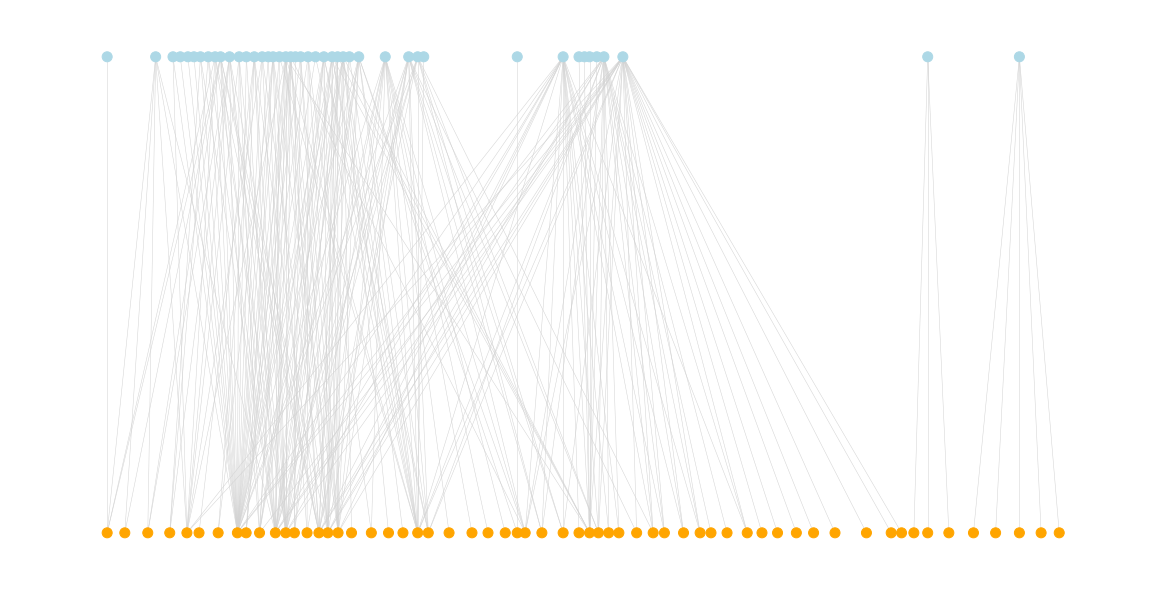

In [93]:
plt.figure(figsize=(16, 8))

pos = nx.nx_agraph.graphviz_layout(g, prog="dot") #"dot", "sfdp", neato
#pos = nx.circular_layout(g)

options = {
    'node_size': 100,
    'width': 0.5,
    'arrows': False,
    'edge_color': "lightgrey"
}
nx.draw(g, node_color=colors, pos=pos, **options)
plt.show()

### Diseases
All reports. Run in browser: https://s.zazuko.com/24fSKE

In [ ]:
query = """
SELECT ?diagnosis ?gde ?specie ?stock ?sick ?infected ?killed ?deceased ?epidemics ?death_cause
WHERE {
  <https://environment.ld.admin.ch/foen/animal-pest/observation/> cube:observation ?obs .
  ?obs disease:epidemics/schema:name ?epidemics;
       disease:diagnosis-date ?diagnosis;
       disease:animals-stock ?stock;
       disease:animals-sick ?sick;
       disease:animals-infected ?infected;
       disease:animals-killed ?killed;
       disease:animals-deceased ?deceased;
       disease:internet-publication ?date;
       disease:death-cause/schema:name ?death_cause;
       disease:animal-specie/schema:name ?specie;
       schema:containedInPlace/schema:name ?gde .
  
  FILTER (LANG(?epidemics) = "de")
  FILTER (LANG(?death_cause) = "de")
  FILTER (LANG(?specie) = "de")
} 
ORDER BY DESC(?diagnosis) ?gde
"""
df = sparql.send_query(query)
df.head()

,diagnosis,gde,specie,stock,sick,infected,killed,deceased,epidemics,death_cause
0,2021-08-03,Adliswil,Schwein,1,1,0,0,0,Enzootische Pneumonie der Schweine,Klinischer Fall
1,2021-08-03,Bonstetten,Bienen,20,3,0,0,0,Sauerbrut der Bienen,Bestandesüberwachung
2,2021-08-03,Egnach,Bienen,15,3,0,0,1,Sauerbrut der Bienen,Klinischer Fall
3,2021-08-02,Alpnach,Bienen,1,1,0,1,0,Sauerbrut der Bienen,Klinischer Fall
4,2021-08-02,Embrach,Rind,22,1,0,0,0,Salmonellose,Klinischer Fall


### Deadly epidemics

Which epidemics lead to death of all animals?

In [ ]:
query = """
SELECT ?diagnosis ?gde ?specie ?stock_deceased ?epidemics ?death_cause
WHERE {
  <https://environment.ld.admin.ch/foen/animal-pest/observation/> cube:observation ?obs .
  ?obs disease:epidemics/schema:name ?epidemics;
       disease:diagnosis-date ?diagnosis;
       disease:animals-stock ?stock_deceased;
       disease:animals-deceased ?stock_deceased;
       disease:internet-publication ?date;
       disease:death-cause/schema:name ?death_cause;
       disease:animal-specie/schema:name ?specie;
       schema:containedInPlace/schema:name ?gde .
  
  FILTER (?stock_deceased > 1)
  FILTER (LANG(?epidemics) = "de")
  FILTER (LANG(?death_cause) = "de")
  FILTER (LANG(?specie) = "de")
} 
ORDER BY DESC(?stock_deceased)
"""

df = sparql.send_query(query)
df.head()

,diagnosis,gde,specie,stock_deceased,epidemics,death_cause
0,2020-02-27,Wileroltigen,Huhn,24000,Salmonella-Infektion des Geflügels,Bestandesüberwachung
1,2020-12-01,Montanaire,Huhn,4000,Salmonella-Infektion des Geflügels,Untersuchungsprogramm
2,2002-09-10,La Grande Béroche,Kaninchen,300,Virale hämorrhagische Krankheit der Kaninchen,Klinischer Fall
3,1996-02-09,Prangins,Kaninchen,70,Virale hämorrhagische Krankheit der Kaninchen,Klinischer Fall
4,2002-04-03,Bellinzona,Kaninchen,67,Virale hämorrhagische Krankheit der Kaninchen,Klinischer Fall


A disease can be higly contagious. It may be hence sefer to kill all animal stock at certain farm, and prevent potential disease spread.

Which epidemics forced farmers to kill all their stock?

In [ ]:
query = """
SELECT ?diagnosis ?gde ?specie ?sick ?infected ?deceased ?stock_killed ?epidemics ?death_cause
WHERE {
  <https://environment.ld.admin.ch/foen/animal-pest/observation/> cube:observation ?obs .
  ?obs disease:epidemics/schema:name ?epidemics;
       disease:diagnosis-date ?diagnosis;
       disease:animals-stock ?stock_killed;
       disease:animals-sick ?sick;
       disease:animals-infected ?infected;
       disease:animals-killed ?stock_killed;
       disease:animals-deceased ?deceased;
       disease:internet-publication ?date;
       disease:death-cause/schema:name ?death_cause;
       disease:animal-specie/schema:name ?specie;
       schema:containedInPlace/schema:name ?gde .
  
  FILTER (?stock_killed > 1)
  FILTER (LANG(?epidemics) = "de")
  FILTER (LANG(?death_cause) = "de")
  FILTER (LANG(?specie) = "de")
} 
ORDER BY DESC(?stock_killed)
"""

df = sparql.send_query(query)
df.head()

,diagnosis,gde,specie,sick,infected,deceased,stock_killed,epidemics,death_cause
0,2014-07-23,Val-de-Travers,Fisch,900,50000,900,90000,Infektiöse Hämatopoietische Nekrose,Ansteckungsverdacht
1,2013-07-01,Cham,Fisch,15000,25000,0,40000,Infektiöse Hämatopoietische Nekrose,Klinischer Fall
2,2004-07-12,Erstfeld,Fisch,0,0,0,30000,Infektiöse Hämatopoietische Nekrose,Klinischer Fall
3,2003-08-12,Courroux,Fisch,0,0,0,16000,Infektiöse Hämatopoietische Nekrose,Klinischer Fall
4,2013-12-31,Agiez,Huhn,0,23,0,16000,Salmonella-Infektion des Geflügels,Bestandesüberwachung
